## Rate Test for CircularLIB Cells

In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os
from datetime import datetime

### 1 Choose model

In [2]:
model = pybamm.lithium_ion.DFN(
    options={
        "particle mechanics": "swelling only",
        "contact resistance":"true"
    }
)
model.print_parameter_info()



TypeError: __init__() got an unexpected keyword argument 'domain'

#### 1.1 Add submodels
Here the wanted submodels are added

In [ ]:
print("Own mechanical submodel is to be added")

Own mechanical submodel is to be added


### 2 Choose parameter and experiment
The parameter set contains all the characterstics of the tested cell

In [ ]:
parameter_values = pybamm.ParameterValues("Chen2020_AH_VM_modified") #_AH_VM_modified


4.359517749721941 0.13099529472227595
0.9108162382141691


#### 2.1 Check electrode SOH of data set

In [ ]:
param =pybamm.LithiumIonParameters()
n_n = parameter_values.evaluate(param.n.n_Li_init)
n_p = parameter_values.evaluate(param.p.n_Li_init)
n_Li = parameter_values.evaluate(param.n_Li_init)
Q_p_init= parameter_values.evaluate(param.p.Q_init)
Q_n_init= parameter_values.evaluate(param.n.Q_init)
electrodes_paralell=parameter_values.evaluate(param.n_electrodes_parallel)
Q_init=Q_p_init+Q_n_init
Q_Li_init=parameter_values.evaluate(param.Q_Li_init)
print("Initial lihthium ions [mol] in positive and negative electrode as well as overall: \n",n_p,"\n",n_n,"\n",n_Li,"\n")
print("Overall capacity in the system: \n",n_Li*pybamm.constants.F/3600*electrodes_paralell) #Ah
print("PyBaMM result for capacity: \n",Q_Li_init)
# print((Q_Li - 1e-6 * Q_p) / Q_n)
# print((Q_Li - 1 * Q_n) / Q_p)
# print((Q_Li - 1 * Q_p) / Q_n)
# print((Q_Li - 1e-6 * Q_n) / Q_p)
check=pybamm.lithium_ion.get_min_max_stoichiometries(parameter_values)
print("min sto neg elec, max sto neg elect, min sto pos elec, max sto pos elec \n",check)


Initial lihthium ions [mol] in positive and negative electrode as well as overall: 
 0.0037073856313623167 
 0.002344778206519449 
 0.006192289472881766 

Overall capacity in the system: 
 1.8255878250322073
PyBaMM result for capacity: 
 0.16596252954838248
min sto neg elec, max sto neg elect, min sto pos elec, max sto pos elec 
 [0.10320261855924749, 0.9999771002616342, 0.22477990565647424, 0.8714302875185937]


#### 2.1 Define experiment

In [ ]:
C3_Rate_test = pybamm.Experiment(
    [
        "Rest for 2490 seconds",
        ("Charge at C/3 until 4.2 V",
        "Hold at 4.2 V until C/20",
        "Rest for 30 minutes",
        "Discharge at C/3 until 3.0 V",
        "Rest for 30 minutes"
        )* 5
    ] 
) #for 1 hours or
pybamm.kinetics.SymmetricButlerVolmer._get_kinetics


<function pybamm.models.submodels.interface.kinetics.butler_volmer.SymmetricButlerVolmer._get_kinetics(self, j0, ne, eta_r, T, u)>

### 3 Choose solver and simulate

In [ ]:
safe_solver = pybamm.CasadiSolver(atol=1e-6, rtol=1e-6, mode="safe", dt_max=2.0)
sim = pybamm.Simulation(model, parameter_values=parameter_values, experiment=C3_Rate_test, solver=safe_solver) #, experiment=C_Rate_test
sol=sim.solve(initial_soc=0.02) #initial_soc=0.5; calc_esoh=False #initial_soc=0 very problematic

### 4 Show results

In [ ]:
model.variables.search("lithiation")
output_variables = ["Negative electrode potential [V]", "Terminal voltage [V]","Positive electrode stoichiometry","Negative electrode stoichiometry","Battery open-circuit voltage [V]","Current [A]","Positive particle concentration overpotential [V]","Negative electrode reaction overpotential [V]","Exchange current density [A.m-2]","Discharge capacity [A.h]","Electrolyte concentration [mol.m-3]","Electrolyte potential [V]"] #,"Cell thickness change [m]"
# output_variables = ["R-averaged negative particle stoichiometry","Negative electrode thickness change [m]","Cell thickness change [m]"]

pybamm.dynamic_plot(sol, output_variables=output_variables, time_unit="hours")

Results for 'lithiation': ['Negative electrode extent of lithiation', 'Positive electrode extent of lithiation', 'X-averaged negative electrode extent of lithiation', 'X-averaged positive electrode extent of lithiation']


interactive(children=(FloatSlider(value=0.0, description='t', max=38.595774074218326, step=0.38595774074218325…

### 4.1 Voltage analysis

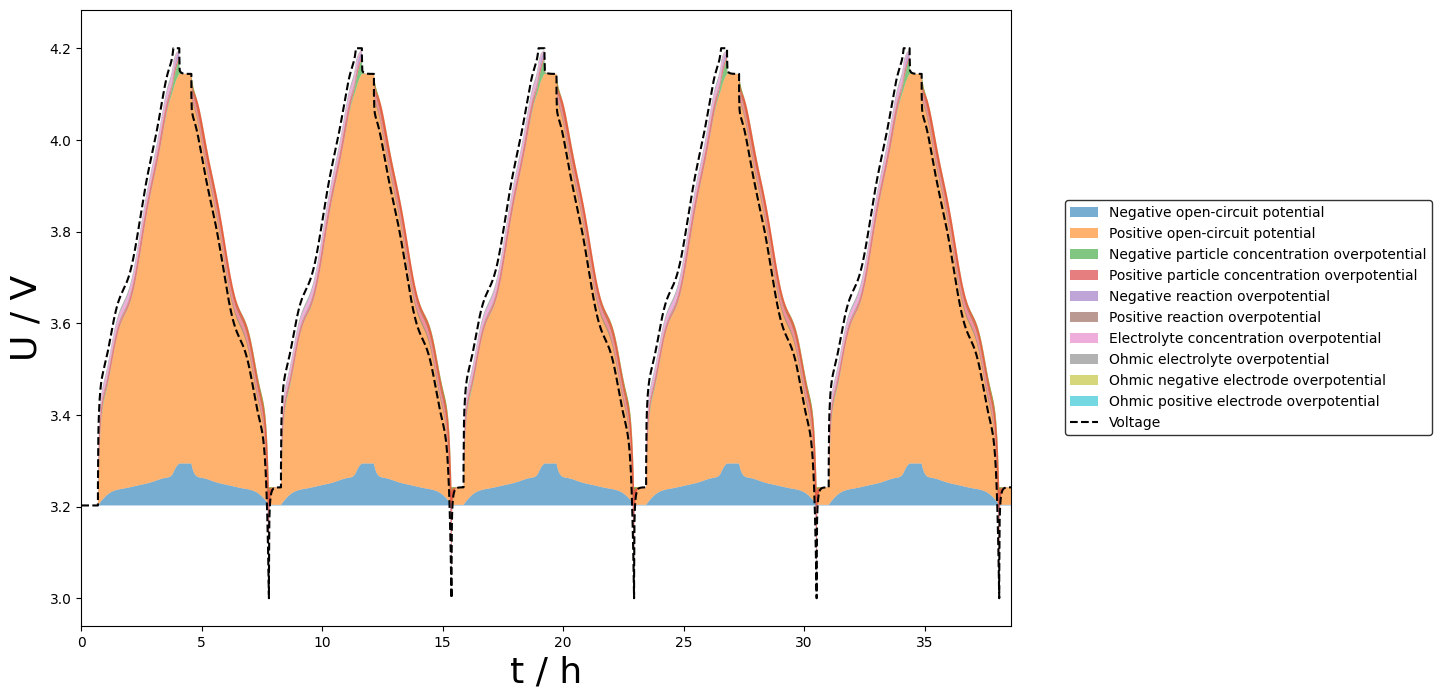

In [ ]:
fig,ax1 = plt.subplots()
fig.set_size_inches(12,8)
pybamm.plot_voltage_components(sol,ax=ax1,split_by_electrode=True)
plt.xlabel("t / h", fontsize=26)
plt.ylabel("U / V", fontsize=26)
# xpoints = np.array([1, 8])
# ypoints = np.array([3, 10])
# plt.plot(xpoints, ypoints)
plt.rcParams.update({'font.size': 18})
date=datetime.now()
today=date.strftime("%Y%m%d")

### 5 Export data for further analysis

In [ ]:
# Find the correct variables
model.variables.search("strain")
sol


No matches found for 'strain'


#### 5.1 Save electrical data

In [ ]:
experiment_date="20250412"
path_csv=pathlib.PureWindowsPath('Y:/07_Experimente_und_Messdaten/Projekte/BLB Pouch_Gold reference/Modelled_data/',experiment_date+"_CircularLIB_Set_C5_Expansion"+".csv")
path_mat=pathlib.PureWindowsPath('Y:/07_Experimente_und_Messdaten/Projekte/BLB Pouch_Gold reference/Modelled_data/',experiment_date+"_CircularLIB_Set_C5_Expansion"+".mat")


# sol.save_data(path_csv, ["Time [s]", "Current [A]", "Terminal voltage [V]", "X-averaged positive electrode potential [V]", "X-averaged negative electrode open-circuit potential [V]"], to_format="csv") # operation voltages in graphite are averaged not meaningful (due to high conductivity?)
sol.save_data(
    path_mat,
    ["Time [s]", "Current [A]", "Terminal voltage [V]", "X-averaged negative electrode potential [V]", "X-averaged positive electrode potential [V]",
    "X-averaged positive electrode open-circuit potential [V]", "X-averaged negative electrode open-circuit potential [V]","Discharge capacity [A.h]",
    "Cell thickness change [m]","Positive electrode thickness change [m]","Negative electrode thickness change [m]","X-averaged positive particle stoichiometry","X-averaged negative particle stoichiometry"],
    to_format="matlab",
    short_names={"Time [s]": "t", "Current [A]": "I", "Terminal voltage [V]": "V", "X-averaged positive electrode potential [V]": "V_we", "X-averaged negative electrode potential [V]": "V_ce",
                "X-averaged positive electrode open-circuit potential [V]": "V_we_OCV", "X-averaged negative electrode open-circuit potential [V]": "V_ce_OCV","Discharge capacity [A.h]": "Cap_dsc",
                "Cell thickness change [m]" : "del_d_cell","Positive electrode thickness change [m]": "del_d_we", "Negative electrode thickness change [m]": "del_d_ce","X-averaged positive particle stoichiometry": "sto_pe", "X-averaged negative particle stoichiometry" : "stp_ne"}
    )


#### 5.2 Save mechanical data

In [ ]:
path_mat_mech=pathlib.PureWindowsPath('Y:/07_Experimente_und_Messdaten/Projekte/BLB Pouch_Gold reference/Modelled_data/',experiment_date+"_CircularLIB_Set_C5_Expansion_R_avg_neg_sto"+".mat")

sol.save_data(
    path_mat_mech,
    ["Time [s]", "R-averaged negative particle stoichiometry", "R-averaged positive particle stoichiometry",
    "Cell thickness change [m]","Positive electrode thickness change [m]","Negative electrode thickness change [m]","X-averaged positive particle stoichiometry","X-averaged negative particle stoichiometry"],
    to_format="matlab",
    short_names={"Time [s]": "t", "R-averaged negative particle stoichiometry": "r_avg_neg_sto", "R-averaged positive particle stoichiometry": "r_avg_pos_sto",
                 "Cell thickness change [m]" : "del_d_cell","Positive electrode thickness change [m]": "del_d_we", "Negative electrode thickness change [m]": "del_d_ce","X-averaged positive particle stoichiometry": "sto_pe", "X-averaged negative particle stoichiometry" : "stp_ne"}
    )
